In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Phase 1: Reading and Exploring the Dataset
# Load the dataset
spotify_data_path = "dataset.csv"  # Replace with your dataset path
data = pd.read_csv(spotify_data_path)

data.head(5)

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

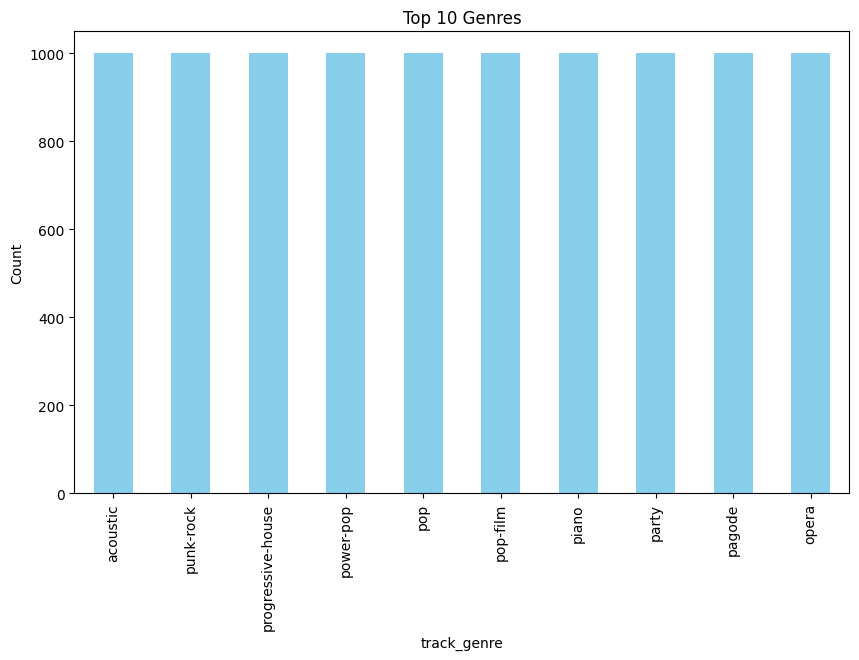

In [4]:
# Examine popularity of top genres
top_genres = data['track_genre'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.title("Top 10 Genres")
plt.ylabel("Count")
plt.show()

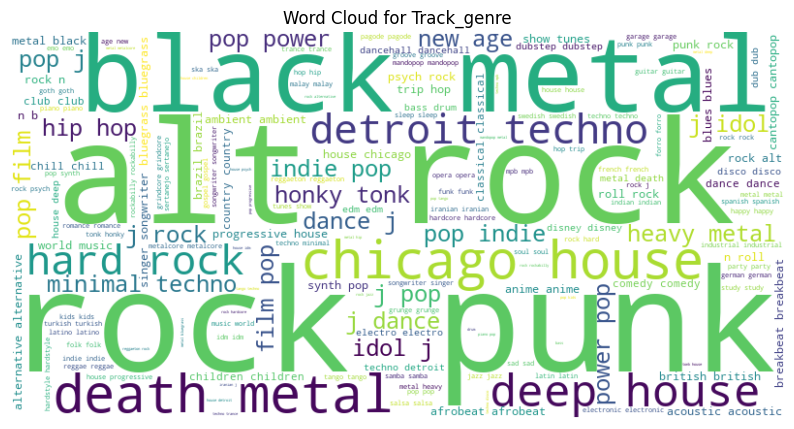

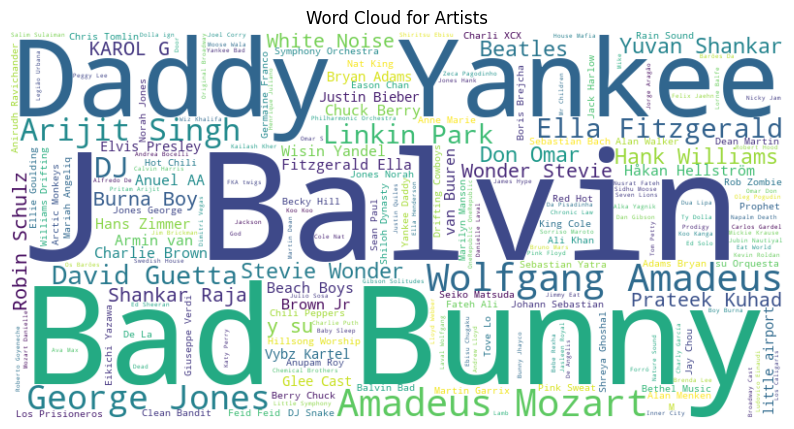

In [6]:
# Generate word clouds for genres and artists
def generate_wordcloud(column):
    text = ' '.join(data[column].dropna().astype(str).values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column.capitalize()}")
    plt.show()

generate_wordcloud('track_genre')
generate_wordcloud('artists')

In [5]:
# Step 1: Data Preprocessing
# Drop unnecessary column
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

# Drop rows with missing values in essential columns
data = data.dropna(subset=['artists', 'album_name', 'track_name'])

In [6]:
# Normalize numerical columns
numerical_cols = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

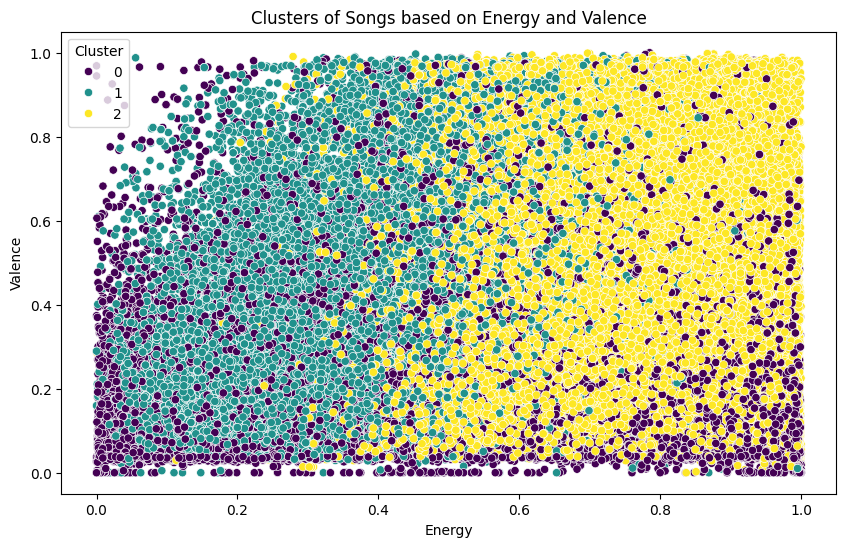

In [8]:
# Step 2: Clustering
cluster_features = [
    'danceability', 'energy', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]


kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(data[cluster_features])

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='energy', y='valence', hue='cluster', palette='viridis')
plt.title("Clusters of Songs based on Energy and Valence")
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.legend(title='Cluster')
plt.show()


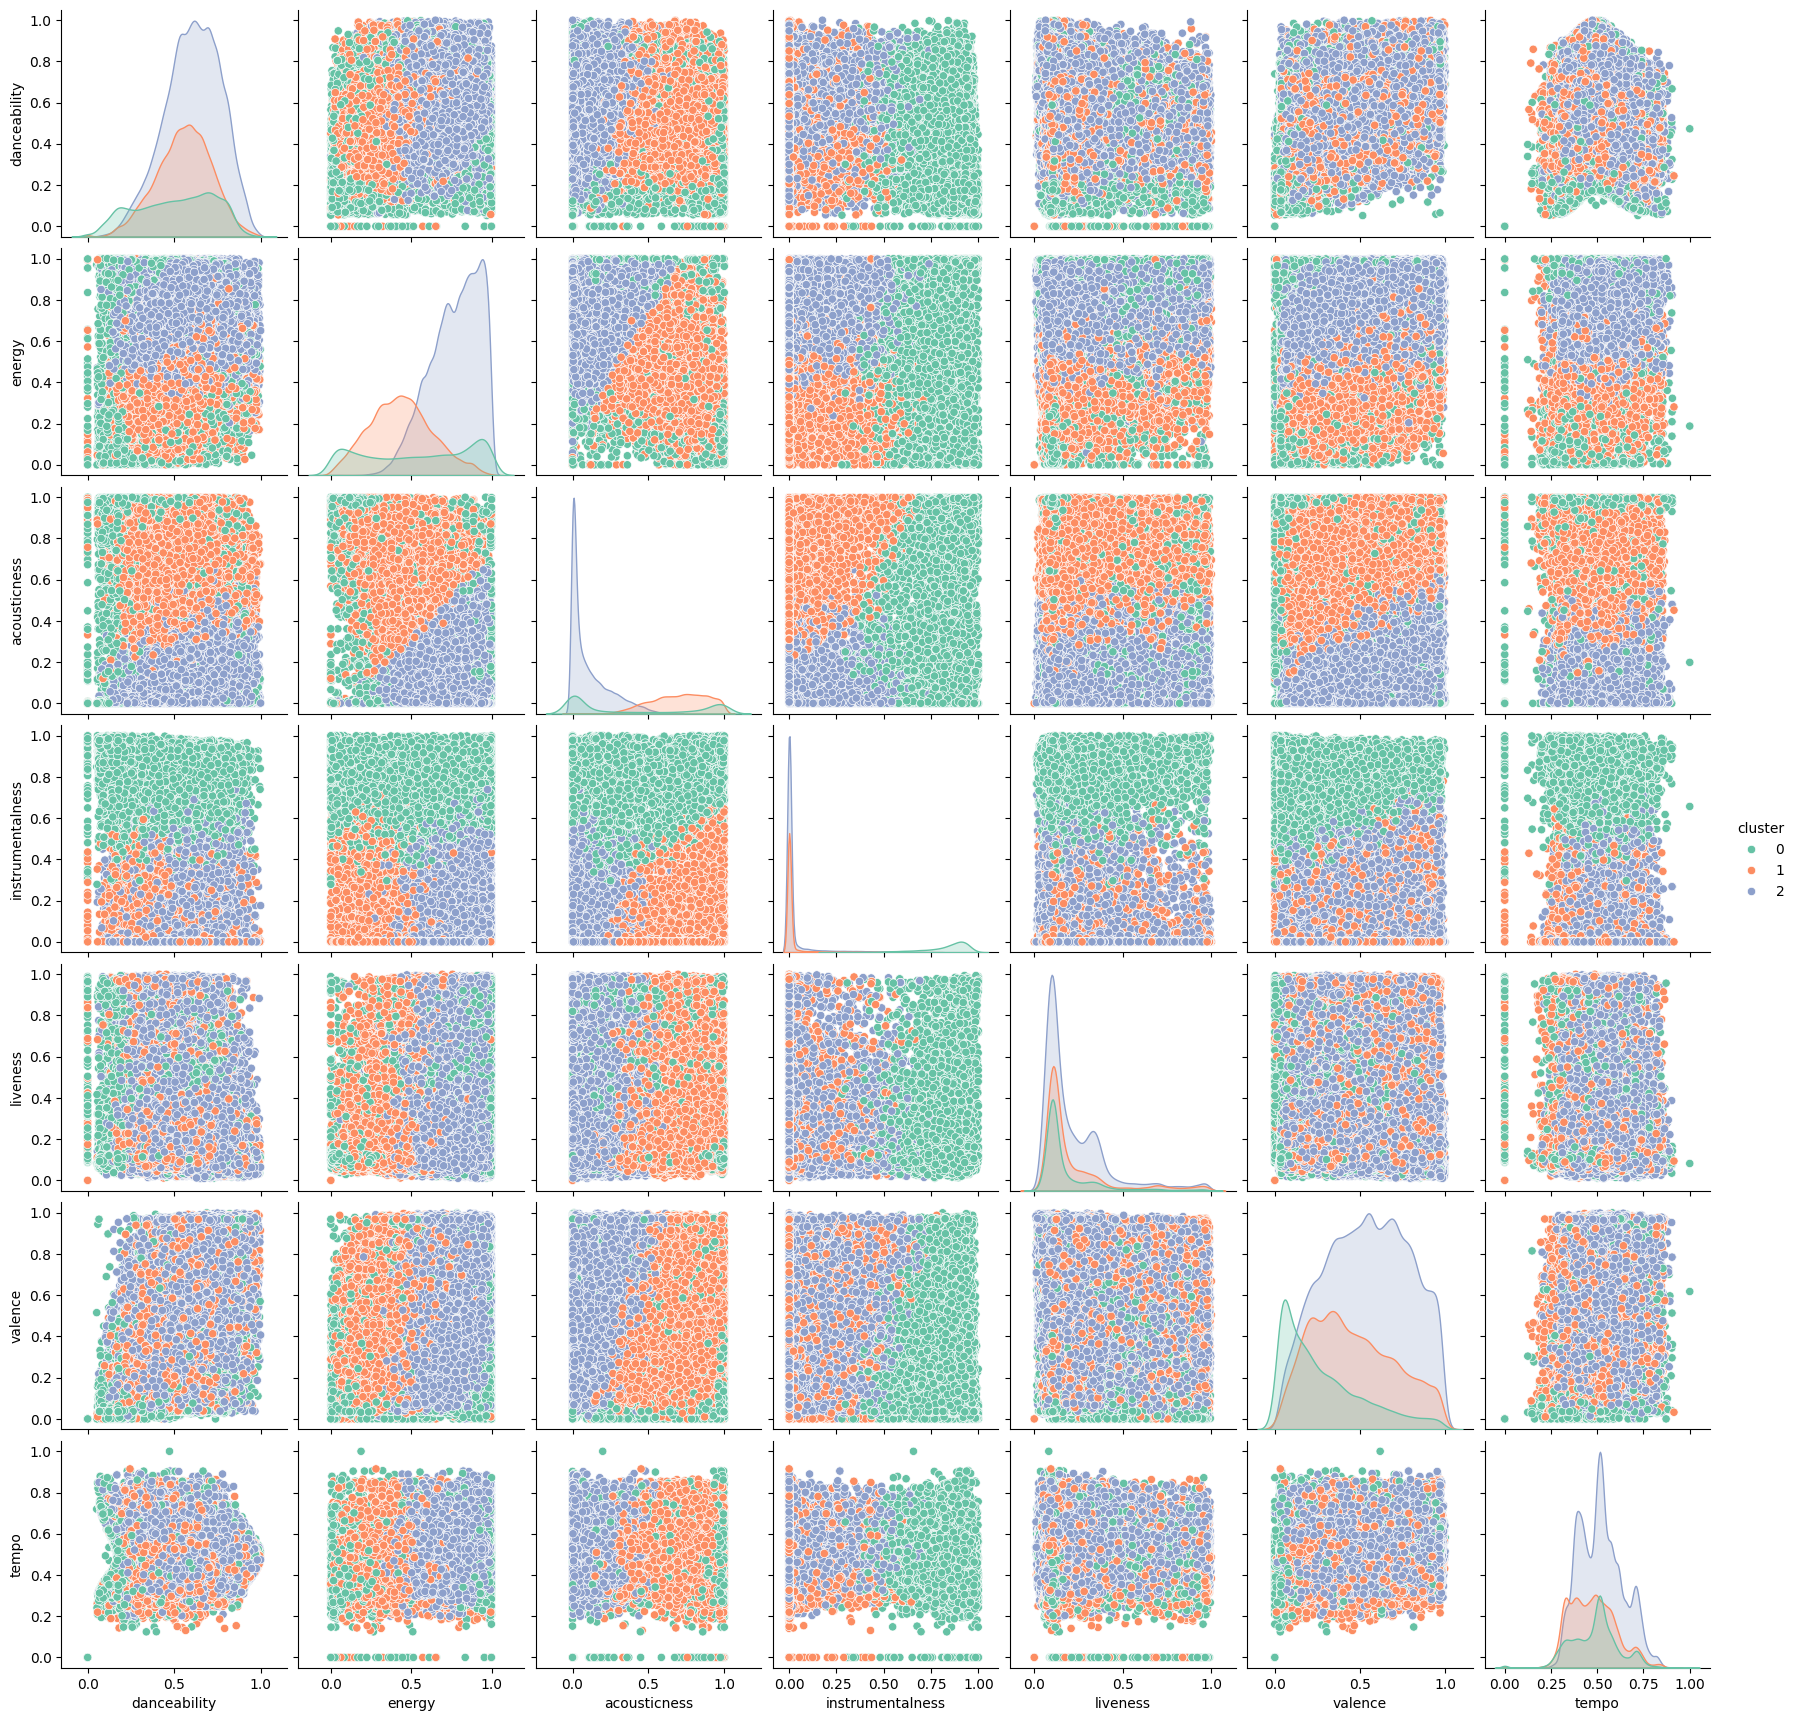

In [15]:
# Visualize clusters
sns.pairplot(data, vars=cluster_features, hue='cluster', palette='Set2')
plt.show()

In [10]:


# Recommendation function
# Step 3: Recommendation Function
def recommend_songs(song_name, data, cluster_features, top_n=10):
    # Filter for the song
    song_data = data[data['track_name'].str.lower() == song_name.lower()]
    
    if song_data.empty:
        return f"Song '{song_name}' not found in the dataset."
    
    # Get the cluster of the input song
    song_cluster = song_data['cluster'].iloc[0]
    
    # Filter for songs in the same cluster
    cluster_songs = data[data['cluster'] == song_cluster]
    
    # Compute similarity scores
    song_vector = song_data[cluster_features].iloc[0].values.reshape(1, -1)
    cluster_vectors = cluster_songs[cluster_features].values
    similarity_scores = cosine_similarity(song_vector, cluster_vectors).flatten()
    
    # Add similarity scores to the dataset
    cluster_songs = cluster_songs.copy()  # Avoid modifying the original data
    cluster_songs['similarity'] = similarity_scores
    
    # Exclude the input song itself and sort by similarity
    recommendations = cluster_songs[cluster_songs['track_name'].str.lower() != song_name.lower()]
    top_recommendations = recommendations.nlargest(top_n, 'similarity')
    
    return top_recommendations[['track_name', 'track_id', 'artists', 'similarity']]

# Example Usage
song_name = "Hold On"  # Replace with the name of a song in your dataset
recommendations = recommend_songs(song_name, data, cluster_features)
print(recommendations)

                  track_name                track_id        artists  \
65678               Hope Not  29fsVDL9T36N0tyD7ByLdI      BLACKPINK   
70453                     分裂  5LlhtR0dYQcYUTapamXiKU       Jay Chou   
60805            Bad Anytime  1jmTuc7xLKVH1PfZqWPNYB         Mavado   
38544             Tid tröste  3Y6K8eaccclu00qImnY1aJ     Mando Diao   
20196        Million Reasons  3YL8jLIarQdM1y2oRClov9      Lady Gaga   
9290       Incomparável Amor  7zPds0jMIhjayTMhALd8FZ  Gabriel Brito   
40146      Incomparável Amor  7zPds0jMIhjayTMhALd8FZ  Gabriel Brito   
70499  Before I Fall in Love  4eItapj64PXkaDmXYcuX6w       CoCo Lee   
54102                    Run  7bQBXiL4dGxZNN6lLSjgP6          Kyson   
54150                    Run  5Y3KCJ2J34Y3nHeNDCxfSI          Kyson   

       similarity  
65678    0.999363  
70453    0.999045  
60805    0.998978  
38544    0.998814  
20196    0.998684  
9290     0.998353  
40146    0.998353  
70499    0.998256  
54102    0.998053  
54150    0.998053 

In [50]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify API credentials
client_id = "your_client_id"
client_secret = "your_client_secret"

# Authenticate with the Spotify API
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

def get_track_details(track_id):
    try:
        # Use the Spotify API to fetch track details
        track = sp.track(track_id)
        
        # Extract relevant details
        track_details = {
            "track_name": track["name"],
            "artists": ", ".join(artist["name"] for artist in track["artists"]),
            "album_name": track["album"]["name"],
            "album_cover": track["album"]["images"][0]["url"] if track["album"]["images"] else None,
            "preview_url": track["preview_url"],  # This might be None if unavailable
            "spotify_url": track["external_urls"]["spotify"]
        }
        return track_details
    except Exception as e:
        print(f"Error fetching track details: {e}")
        return None

# Example usage
track_id = "7zPds0jMIhjayTMhALd8FZ"  # Replace with a valid track ID
details = get_track_details(track_id)

if details:
    print("Track Name:", details["track_name"])
    print("Artists:", details["artists"])
    print("Album:", details["album_name"])
    print("Album Cover URL:", details["album_cover"])
    print("Preview URL:", details["preview_url"])
    print("Spotify URL:", details["spotify_url"])
else:
    print("Failed to retrieve track details.")

Track Name: Incomparável Amor
Artists: Gabriel Brito
Album: Incomparável Amor
Album Cover URL: https://i.scdn.co/image/ab67616d0000b273dab6c984d103ea1582908b34
Preview URL: None
Spotify URL: https://open.spotify.com/track/7zPds0jMIhjayTMhALd8FZ
